# <center>Intra-day Forecasting of Nasdaq: The Role of Market Sentiment </center>
## <center>Nuno Fernandes </center>

In [181]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


from newsapi import NewsApiClient

import helper
import INDEXES

In [4]:
# Initialize the API client with your API key
api_key = 'fcd8f6df1ed34bf0baf86b85bf4fb677'
newsapi = NewsApiClient(api_key=api_key)

In [174]:
normalized_sentiment_sums, sentiments = helper.finbert()
df_full = helper.dataframe_plotting(sentiments,normalized_sentiment_sums)

In [165]:
# Example usage
indexes = INDEXES.indexes_class()
indexes.retrieve_data_normalize()

# Access the fetched data
lista_ticks = indexes.retrieve_data_normalize()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [175]:
for key in lista_ticks.keys():
    df_full[key] = lista_ticks[key]

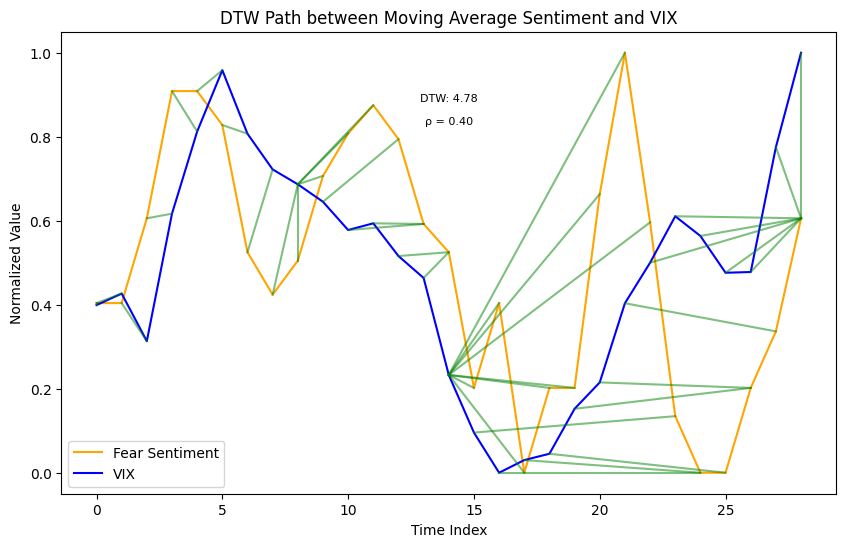

In [184]:
df_full['Moving_Average'] = df_full['Sentiment'].rolling(window=3).mean()

#Prepare the series for DTW, ensuring they have the same length
series1 = pd.Series(df_full["Moving_Average"].values).dropna()
series2 = pd.Series(df_full["^VIX"].rolling(window=3).mean().values).dropna()

# Align lengths of series if necessary
min_length = min(len(series1), len(series2))
aligned_series1 = series1.iloc[-min_length:].reset_index(drop=True)
aligned_series2 = series2.iloc[-min_length:].reset_index(drop=True)

# Normalize the aligned series
normalized_series1 = helper.min_max_normalize(aligned_series1)
normalized_series2 = helper.min_max_normalize(aligned_series2)

# Apply DTW to the normalized series
dtw_cost_matrix, dtw_path = helper.fill_dtw_cost_matrix(normalized_series1, normalized_series2)
dtw_distance = dtw_cost_matrix[-1, -1]  # Get the DTW distance

# Plot DTW path for visualization
plt.figure(figsize=(10, 6))
plt.plot(normalized_series1, label='Fear Sentiment', color='orange')
plt.plot(normalized_series2, label='VIX', color='blue')

# Highlight the DTW path
for (index1, index2) in dtw_path:
    plt.plot([index1, index2], [normalized_series1.iloc[index1], normalized_series2.iloc[index2]], color='green', alpha=0.5)

plt.title('DTW Path between Moving Average Sentiment and VIX')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.legend()

plt.annotate(f'DTW: {dtw_distance:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=8,
             ha='center', color='black')

correlation, _ = spearmanr(normalized_series1, normalized_series2)
plt.annotate(f'ρ = {correlation:.2f}', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=8,
             ha='center', color='black')

plt.show()


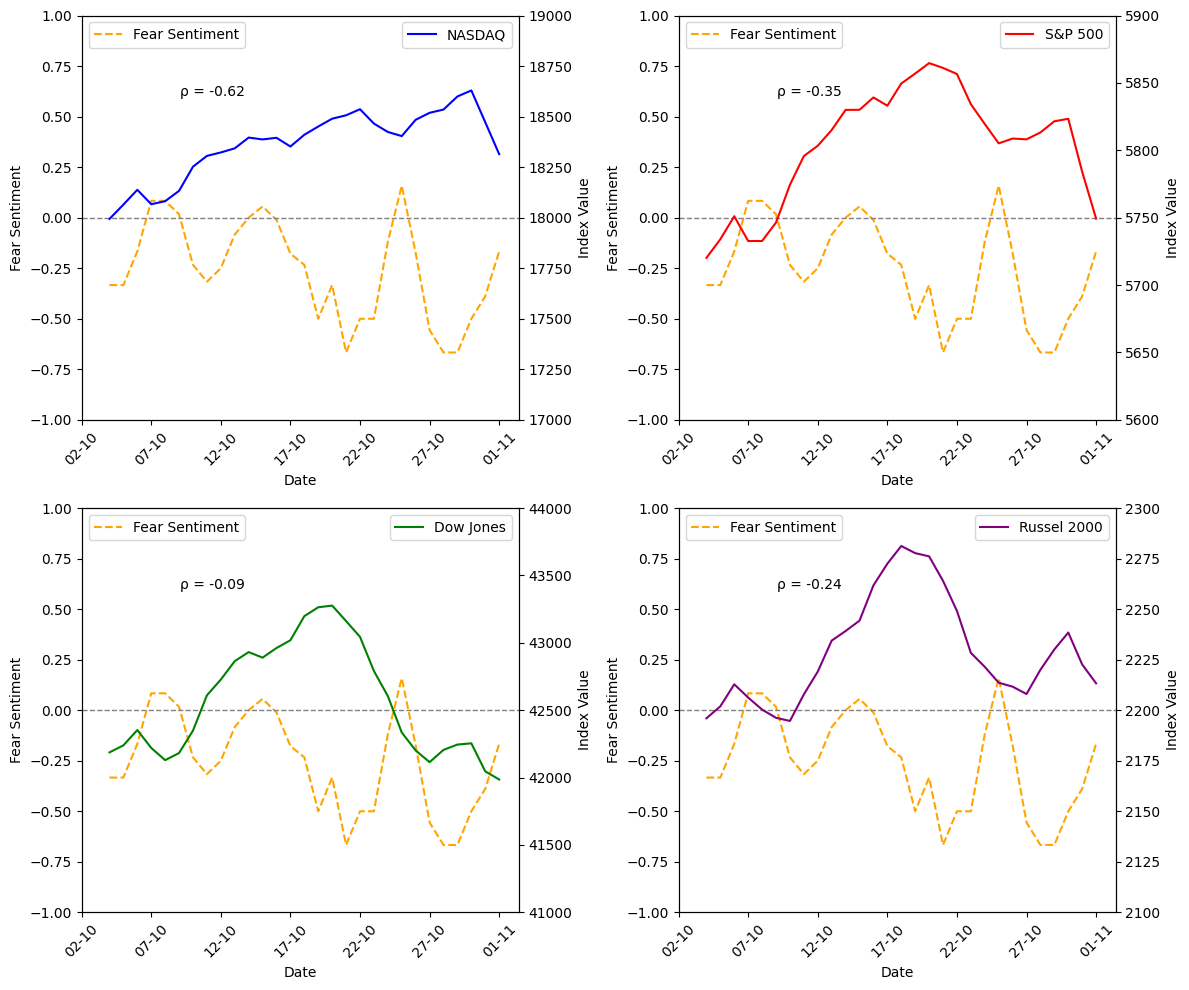

In [190]:
# List of tickers you want to visualize
tickers = ['^IXIC','^GSPC', '^DJI', "^RUT"]
aux = {'^IXIC':["NASDAQ","blue"],'^GSPC':["S&P 500","red"], '^DJI':["Dow Jones","green"], "^RUT":["Russel 2000","purple"]}

# Create a grid of plots (2 rows x 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Loop through each ticker and create a subplot
for ax, ticker in zip(axes, tickers):
    # Plot moving average sentiment on the primary y-axis
    ax.plot(df_full.index, df_full['Moving_Average'], linestyle='--', color='orange', label='Fear Sentiment')
    ax.set_ylim(-1, 1)
    
    # Create a secondary y-axis for each index
    ax2 = ax.twinx()  # Create a twin Axes sharing the x-axis
    # Plot moving average of the ticker
    ticker_moving_avg = df_full[ticker].rolling(window=3).mean()
    ax2.plot(df_full.index, ticker_moving_avg, linestyle='-', color=aux[ticker][1], label=aux[ticker][0])

    # Set limits for the secondary y-axis based on the specific index
    if ticker == '^GSPC':
        ax2.set_ylim(5600, 5900)  # Adjust according to actual range
        legend = "S&P 500"
    elif ticker == '^IXIC':
        ax2.set_ylim(17000, 19000)  # Adjust according to actual range
        legend = "NASDAQ"
    elif ticker == '^DJI':
        ax2.set_ylim(41000, 44000)  # Adjust according to actual range
        legend = "Dow Jones"
    elif ticker == '^RUT':
        ax2.set_ylim(2100, 2300)  # Adjust according to actual range
        legend = "Russel 2000"

    # Adding a line to indicate zero sentiment
    ax.axhline(0, color='grey', lw=1, ls='--')

    # Set titles and labels
    ax.set_title(f'')
    ax.set_xlabel('Date')
    ax.set_ylabel('Fear Sentiment')
    ax2.set_ylabel("Index Value")  # Label for secondary y-axis
    
    # Set x-ticks to show only every 5th day
    tick_indices = range(0, len(df_full.index), 5)  # Get indices for every 5th day
    ax.set_xticks(df_full.index[tick_indices])  # Set ticks to the index for every 5th day
    ax.set_xticklabels(df_full.index[tick_indices].strftime('%d-%m'), rotation=45)  # Format as day-month

    # Add legends for both y-axes
    ax.legend(loc='upper left')  # Legend for primary y-axis
    ax2.legend(loc='upper right')  # Legend for secondary y-axis

    correlation, _ = spearmanr(df_full['Moving_Average'].dropna(), ticker_moving_avg.dropna())  # Calculate correlation
    

    # Annotate the plot with the correlation value
    ax.annotate(f'ρ = {correlation:.2f}', 
            xy=(0.3, 0.8), 
            xycoords='axes fraction', 
            fontsize=10, 
            ha='center', 
            color='black')


# Adjust layout
plt.tight_layout()
plt.show()


In [111]:
# Assuming df_full has your NASDAQ index data under '^IXIC' and sentiment data under 'Sentiment'
df_full['Sentiment_moving'] = df_full['Sentiment'].rolling(window=3).mean()
df_full['^IXIC_moving'] = df_full['^IXIC'].rolling(window=3).mean()

df_full['^VIX_moving'] = df_full['^VIX'].rolling(window=3).mean()

df_full=df_full.dropna()

# Separate dependent (NASDAQ index) and independent (Sentiment) variables
X = df_full[['^VIX_moving']]  # You can add more columns if you have more sentiment factors
y = df_full['^IXIC_moving']

# Add a constant to the independent variable matrix for the intercept
X = sm.add_constant(X)

# 2. Fit the Model
model = sm.OLS(y, X)
results = model.fit()

# 3. Print the Results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           ^IXIC_moving   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4.123
Date:                Sat, 02 Nov 2024   Prob (F-statistic):             0.0522
Time:                        17:49:05   Log-Likelihood:                -187.68
No. Observations:                  29   AIC:                             379.4
Df Residuals:                      27   BIC:                             382.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.957e+04    597.998     32.732      

In [112]:
# Separate dependent (NASDAQ index) and independent (Sentiment) variables
X = df_full[['Sentiment_moving']]  # You can add more columns if you have more sentiment factors
y = df_full['^IXIC_moving']

# Add a constant to the independent variable matrix for the intercept
X = sm.add_constant(X)

# 2. Fit the Model
model = sm.OLS(y, X)
results = model.fit()

# 3. Print the Results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ^IXIC_moving   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     11.07
Date:                Sat, 02 Nov 2024   Prob (F-statistic):            0.00254
Time:                        17:49:12   Log-Likelihood:                -184.76
No. Observations:                  29   AIC:                             373.5
Df Residuals:                      27   BIC:                             376.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.826e+04     40.097  

In [118]:
# Define the maximum number of lags
max_lag = 5

# Ensure there are no NaNs in the NASDAQ data initially
nasdaq_series = df_full['^IXIC'].dropna()

# Create lagged variables for the NASDAQ index
for lag in range(1, max_lag + 1):
    df_full[f'NASDAQ_Lag_{lag}'] = nasdaq_series.shift(lag)

# Drop rows with NaN values caused by lagging
df_full = df_full.dropna()

# Define independent (X) and dependent (y) variables
X = df_full[[f'NASDAQ_Lag_{lag}' for lag in range(1, max_lag + 1)]]
y = df_full['^IXIC']

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary, which includes R-squared to interpret variance explained
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  ^IXIC   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.012
Date:                Sat, 02 Nov 2024   Prob (F-statistic):              0.443
Time:                        17:51:04   Log-Likelihood:                -136.56
No. Observations:                  22   AIC:                             285.1
Df Residuals:                      16   BIC:                             291.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.466e+04   6011.152      2.439   

In [116]:
# Define the maximum number of lags
max_lag = 5


nasdaq_series = df_full['^IXIC_moving'].dropna()
sentiment_series = df_full['Sentiment_moving'].dropna()

# Create lagged variables for the NASDAQ index
for lag in range(1, max_lag + 1):
    df_full[f'NASDAQ_Lag_{lag}'] = nasdaq_series.shift(lag)

# Drop rows with NaN values caused by lagging
df_full_ = df_full.dropna()

# Define independent (X) and dependent (y) variables, including Sentiment_moving as an additional predictor
X = df_full_[[f'NASDAQ_Lag_{lag}' for lag in range(1, max_lag + 1)] + ['Sentiment_moving']]
y = df_full_['^IXIC_moving']

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary, which includes R-squared to interpret variance explained
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           ^IXIC_moving   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     9.985
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           0.000158
Time:                        17:50:42   Log-Likelihood:                -112.02
No. Observations:                  22   AIC:                             238.0
Df Residuals:                      15   BIC:                             245.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.013e+04   2908.446  

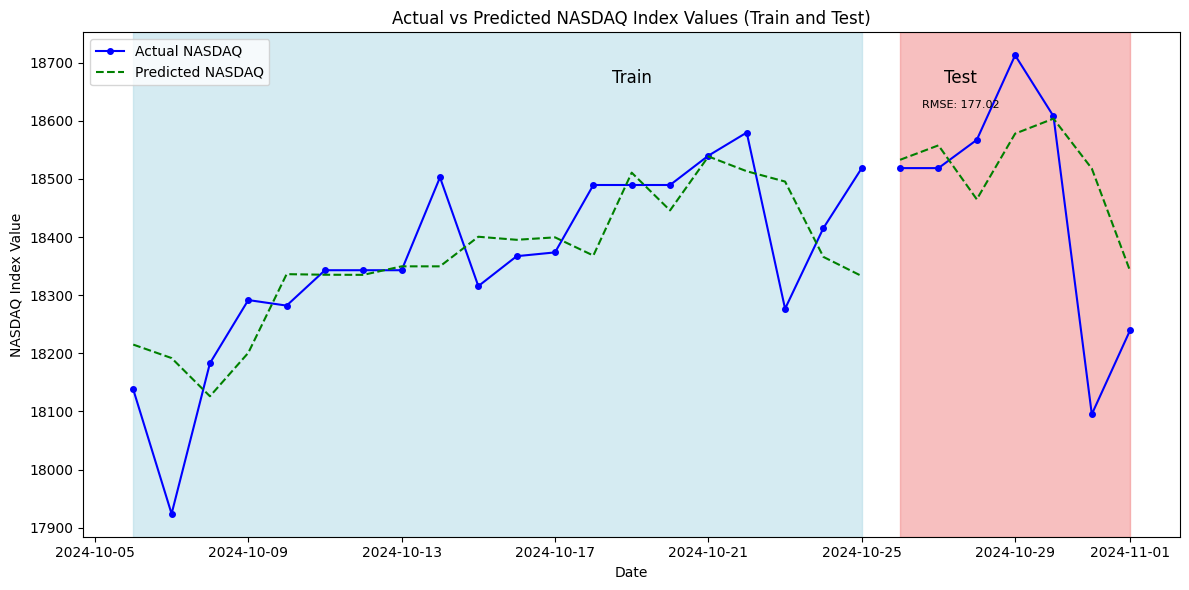

In [171]:
# Assuming df_full is your DataFrame and it has a 'Sentiment' column

# Step 1: Create lagged variables for the NASDAQ index
max_lag = 2  # Since we want lag-1 and lag-2
nasdaq_series = df_full['^IXIC'].dropna()

# Create lagged variables
for lag in range(1, max_lag + 1):
    df_full[f'NASDAQ_Lag_{lag}'] = nasdaq_series.shift(lag)

# Step 2: Drop rows with NaN values caused by lagging
df_full = df_full.dropna()

# Step 3: Define training and testing sets
test_size = 7  # Last 7 days for testing
train_size = len(df_full) - test_size

train_data = df_full.iloc[:train_size]
test_data = df_full.iloc[train_size:]

# Step 4: Define independent (X) and dependent (y) variables for training
X_train = train_data[['Sentiment', 'NASDAQ_Lag_1', 'NASDAQ_Lag_2']]
y_train = train_data['^IXIC']

# For testing
X_test = test_data[['Sentiment', 'NASDAQ_Lag_1', 'NASDAQ_Lag_2']]
y_test = test_data['^IXIC']

# Step 5: Fit the model using OLS
# Add a constant for the intercept
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

# Step 6: Make predictions on both train and test sets
y_train_pred = model.predict(X_train)  # Predictions for the training set
X_test = sm.add_constant(X_test)
y_test_pred = model.predict(X_test)  # Predictions for the testing set

# Step 7: Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Step 8: Plot the actual vs predicted values for both train and test sets
plt.figure(figsize=(12, 6))

# Fill background for training and testing data
plt.axvspan(train_data.index[0], train_data.index[-1], color='lightblue', alpha=0.5, label='')
plt.axvspan(test_data.index[0], test_data.index[-1], color='lightcoral', alpha=0.5, label='')

# Plot training data
plt.plot(train_data.index, y_train, label='', color='blue', marker='o', markersize=4)
plt.plot(train_data.index, y_train_pred, label='', color='green', linestyle='--')

# Plot testing data
plt.plot(test_data.index, y_test, label='Actual NASDAQ', color='blue', marker='o', markersize=4)
plt.plot(test_data.index, y_test_pred, label='Predicted NASDAQ', color='green', linestyle='--')

# Title and labels
plt.title('Actual vs Predicted NASDAQ Index Values (Train and Test)')
plt.xlabel('Date')
plt.ylabel('NASDAQ Index Value')
plt.legend()
plt.xticks()

# Annotate RMSE
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.8, 0.85), xycoords='axes fraction', fontsize=8,
             ha='center', color='black')

# Annotate training and testing regions
plt.annotate('Train', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12,
             ha='center', color='black')
plt.annotate('Test', xy=(0.8, 0.9), xycoords='axes fraction', fontsize=12,
             ha='center', color='black')

plt.tight_layout()
plt.show()
